# **Sale Price Analysis Notebook**

## Objectives

* Data Exploration of missing data using ProfileReport
* Correlation and PPS analysis
* Visualising findings in plots that can be later used in a Streamlit app.

## Inputs

* outputs/datasets/collection/house_prices_records.csv 

## Outputs

* Generate plots to be used later in a Streamlit app. 

## Additional Comments

* CRISP-DM: *Data Understanding* 

---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [ ]:
import os
current_dir = os.getcwd()
current_dir

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [ ]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

Confirm the new current directory

In [ ]:
current_dir = os.getcwd()
current_dir

## Import Libraries

In [ ]:
# import all necessary packages and libraries for the notebook
import pandas as pd
from pandas_profiling import ProfileReport
from feature_engine.encoding import OneHotEncoder
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
import ppscore as pps

## Load Collected Data

In [ ]:
df_raw_path = "outputs/datasets/collection/house_prices_records.csv"
df = pd.read_csv(df_raw_path)
df.head(5)

---

# Data Exploration

Generate panda profiling report. This will help us to get more familiar with the content of the dataset, check variable type and distribution, missing levels and how each variable may related to our target.

In [ ]:
pandas_report = ProfileReport(df=df, minimal=True)
pandas_report.to_notebook_iframe()

#### Observations

* Data set of 24 colums: 20 numerical and 4 text;
* Nearly 10% of total data is missing: 9 variables have data missing;
* EnclosedPorch and WoodDeckSF have 90.7% and 89.4% missing values respectively.

---

# Correlation and PPS Analysis

Correlation analysis is performed to evaluate the strength and direction of the linear relationship between variables
The following code taken from CI Churnometer project is designed to visualise the correlation and Predictive Power Score (PPS) matrices of the dataframe.

Let's first examine both the Spearman and Pearson coefficients and generate bar plots on most important features.


In [51]:
corr_spearman = df.corr(method='spearman')['SalePrice'].sort_values(key=abs, ascending=False)[1:].head(8)
corr_spearman

OverallQual     0.809829
GrLivArea       0.731310
YearBuilt       0.652682
GarageArea      0.649379
TotalBsmtSF     0.602725
GarageYrBlt     0.593788
1stFlrSF        0.575408
YearRemodAdd    0.571159
Name: SalePrice, dtype: float64

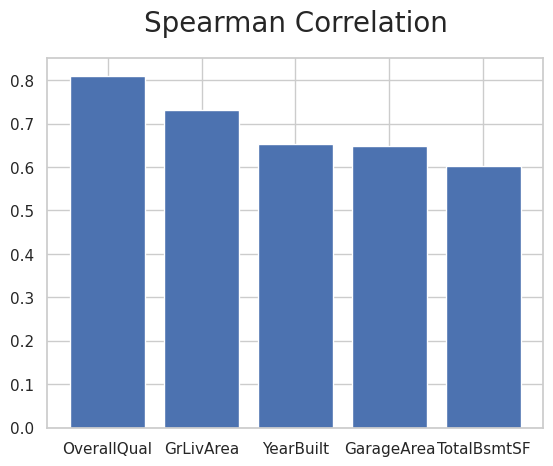

In [52]:
plt.bar(x=corr_spearman[:5].index, height=corr_spearman[:5])
plt.title("Spearman Correlation", fontsize=20, y=1.05)
plt.show()

In [53]:
corr_pearson = df.corr(method='pearson')['SalePrice'].sort_values(key=abs, ascending=False)[1:].head(8)
corr_pearson

OverallQual     0.790982
GrLivArea       0.708624
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
YearBuilt       0.522897
YearRemodAdd    0.507101
GarageYrBlt     0.486362
Name: SalePrice, dtype: float64

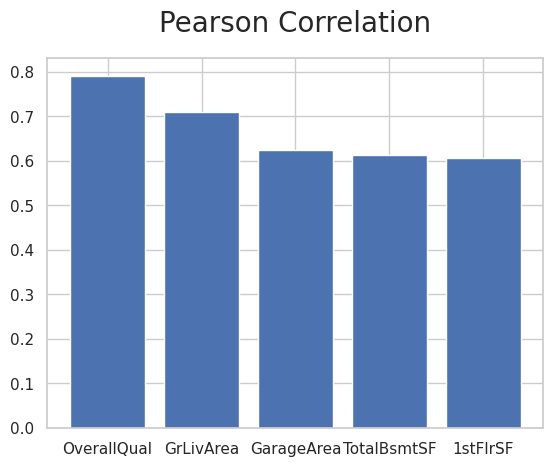

In [54]:
plt.bar(x=corr_pearson[:5].index, height=corr_pearson[:5])
plt.title("Pearson Correlation", fontsize=20, y=1.05)
plt.show()

In [55]:
top_n = 5
set(corr_pearson[:top_n].index.to_list() + corr_spearman[:top_n].index.to_list())

{'1stFlrSF',
 'GarageArea',
 'GrLivArea',
 'OverallQual',
 'TotalBsmtSF',
 'YearBuilt'}

The most correlated variables (correlation of values > 0.5) considering both spearman and pearson correlations are:  
'1stFlrSF', 'GarageArea', 'GrLivArea', 'OverallQual', 'TotalBsmtSF', and 'YearBuilt'.

In [56]:
vars_to_study = ['1stFlrSF', 'GarageArea', 'GrLivArea', 'OverallQual', 'TotalBsmtSF','YearBuilt']
vars_to_study

['1stFlrSF',
 'GarageArea',
 'GrLivArea',
 'OverallQual',
 'TotalBsmtSF',
 'YearBuilt']

In [57]:
def heatmap_corr(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=bool)
        mask[np.triu_indices_from(mask)] = True
        mask[abs(df) < threshold] = True

        fig, axes = plt.subplots(figsize=figsize)
        sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                    mask=mask, cmap='viridis', annot_kws={"size": font_annot}, ax=axes,
                    linewidth=0.5
                    )
        axes.set_yticklabels(df.columns, rotation=0)
        plt.ylim(len(df.columns), 0)
        plt.show()


def heatmap_pps(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=bool)
        mask[abs(df) < threshold] = True
        fig, ax = plt.subplots(figsize=figsize)
        ax = sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                         mask=mask, cmap='rocket_r', annot_kws={"size": font_annot},
                         linewidth=0.05, linecolor='grey')
        plt.ylim(len(df.columns), 0)
        plt.show()


def CalculateCorrAndPPS(df):
    df_corr_spearman = df.corr(method="spearman")
    df_corr_pearson = df.corr(method="pearson")

    pps_matrix_raw = pps.matrix(df)
    pps_matrix = pps_matrix_raw.filter(['x', 'y', 'ppscore']).pivot(columns='x', index='y', values='ppscore')

    pps_score_stats = pps_matrix_raw.query("ppscore < 1").filter(['ppscore']).describe().T
    print("PPS threshold - check PPS score IQR to decide threshold for heatmap \n")
    print(pps_score_stats.round(3))

    return df_corr_pearson, df_corr_spearman, pps_matrix


def DisplayCorrAndPPS(df_corr_pearson, df_corr_spearman, pps_matrix, CorrThreshold, PPS_Threshold,
                      figsize=(20, 12), font_annot=8):

    print("\n")
    print("* Analyse how the target variable for your ML models are correlated with other variables (features and target)")
    print("* Analyse multi-colinearity, that is, how the features are correlated among themselves")

    print("\n")
    print("*** Heatmap: Spearman Correlation ***")
    print("It evaluates monotonic relationship \n")
    heatmap_corr(df=df_corr_spearman, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Pearson Correlation ***")
    print("It evaluates the linear relationship between two continuous variables \n")
    heatmap_corr(df=df_corr_pearson, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Power Predictive Score (PPS) ***")
    print(f"PPS detects linear or non-linear relationships between two columns.\n"
          f"The score ranges from 0 (no predictive power) to 1 (perfect predictive power) \n")
    heatmap_pps(df=pps_matrix, threshold=PPS_Threshold, figsize=figsize, font_annot=font_annot)

Calculate the Correlations and Power Predictive Score.

In [58]:
df_corr_pearson, df_corr_spearman, pps_matrix = CalculateCorrAndPPS(df)

/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/workspa

PPS threshold - check PPS score IQR to decide threshold for heatmap 

         count   mean    std  min  25%  50%    75%    max
ppscore  552.0  0.055  0.104  0.0  0.0  0.0  0.066  0.702


Then we display the correlations and pps by calling the DisplayCorrAndPPS function we defined above



* Analyse how the target variable for your ML models are correlated with other variables (features and target)
* Analyse multi-colinearity, that is, how the features are correlated among themselves


*** Heatmap: Spearman Correlation ***
It evaluates monotonic relationship 



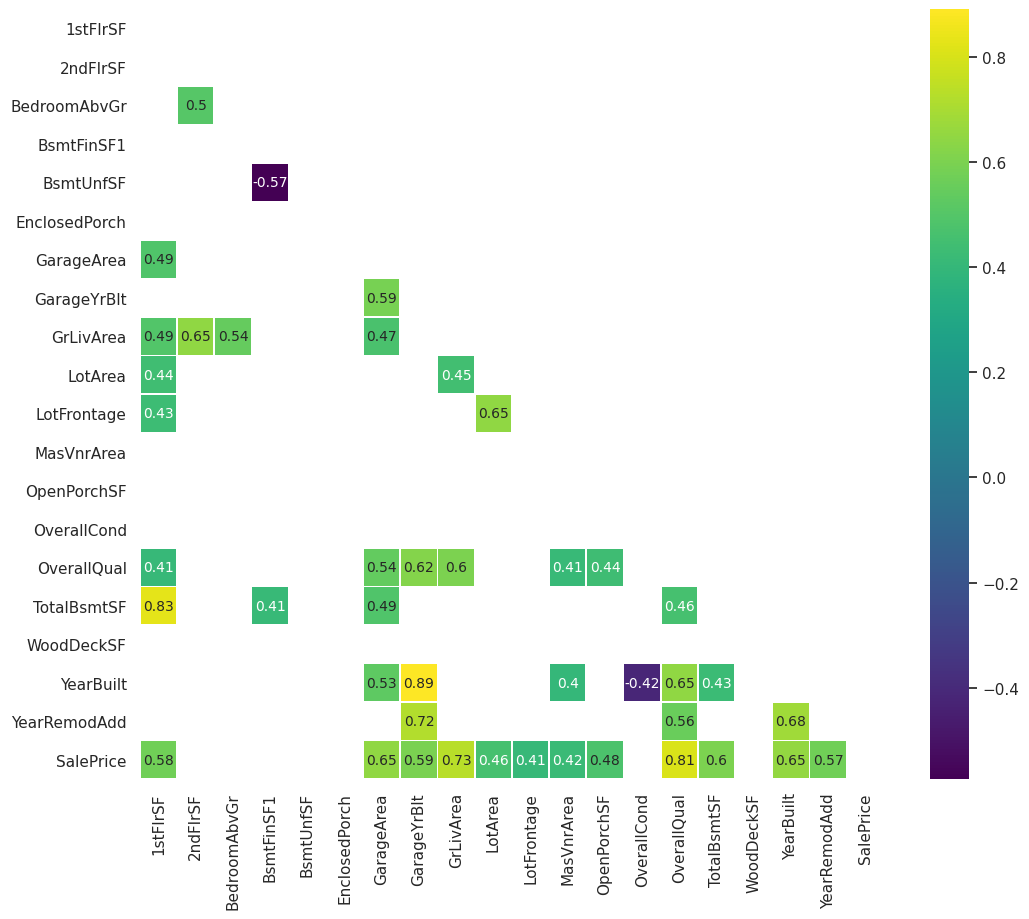



*** Heatmap: Pearson Correlation ***
It evaluates the linear relationship between two continuous variables 



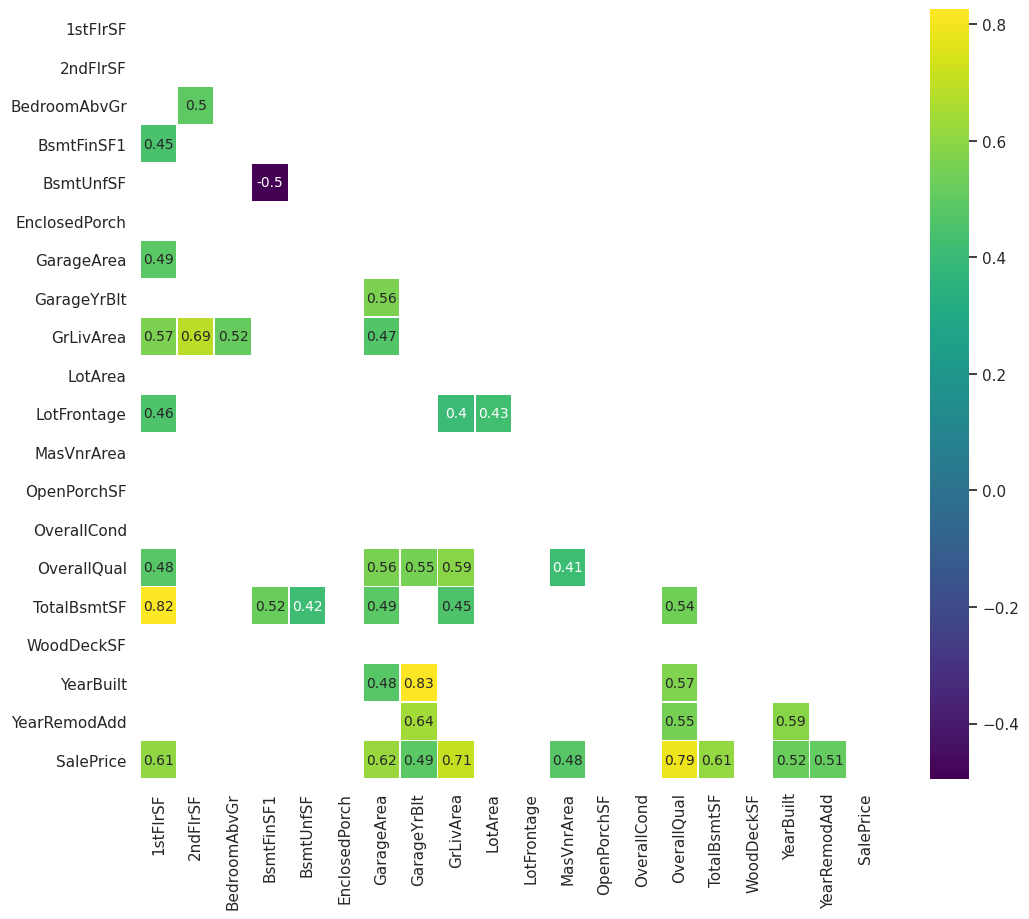



*** Heatmap: Power Predictive Score (PPS) ***
PPS detects linear or non-linear relationships between two columns.
The score ranges from 0 (no predictive power) to 1 (perfect predictive power) 



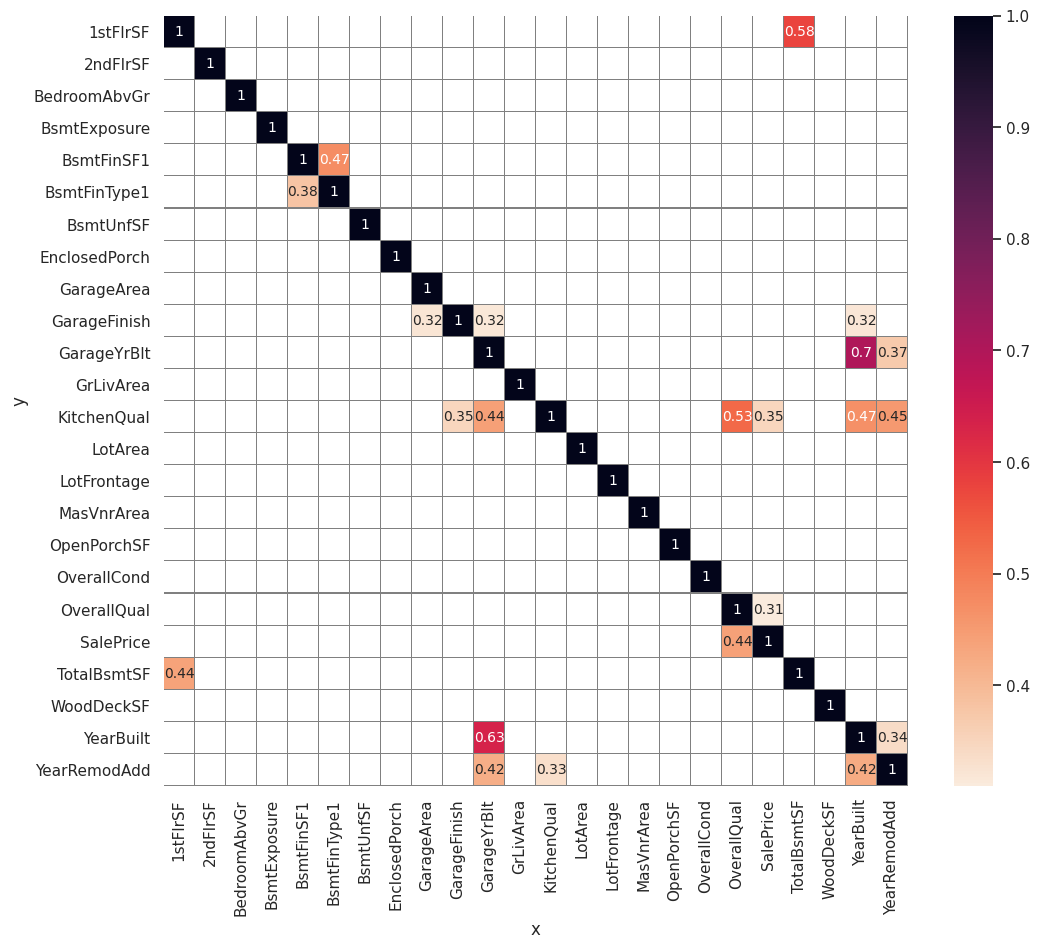

In [59]:
DisplayCorrAndPPS(df_corr_pearson = df_corr_pearson,
                  df_corr_spearman = df_corr_spearman, 
                  pps_matrix = pps_matrix,
                  CorrThreshold = 0.4, PPS_Threshold =0.3,
                  figsize=(12,10), font_annot=10)

Considering the business requirement of seeing which property features most greatly influence its sale price, and after reviewing these visualisations with regard to the SalePrice variable we have the following observations:

* top 5 correlated to SalePrice are: 'GarageArea', 'GrLivArea', 'OverallQual', 'TotalBsmtSF', and 'YearBuilt'.

* OverallQual and GrLivArea have the strongest predictive power for the target variable.

Create a new dataframe with the only selected variables and SalePrice for exploratory data analysis (EDA).

In [ ]:
df_eda = df.filter(vars_to_study + ['SalePrice']) 
df_eda.head(3)

## Distribution of Sales Price

Plot each variable as a scatter plot against the sale price.

In [ ]:
target_var = 'SalePrice'

def plot_lm(df, col, target_var):
  """
  Function to create linear regression plots of the 'SalePrice' and
  variables with continuous values.  
  """
  plt.figure(figsize=(12, 5))
  sns.lmplot(data=df, x=col, y=target_var, ci=None)
  plt.title(f"{col}", fontsize=20)
  plt.show()

def plot_joint(df, col, target_var):
  """
  Function to create a joint plot of the 'SalePrice' and
  categorical variables.  
  """
  plt.figure(figsize=(8, 5))
  sns.jointplot(data=df, x=col, y=target_var) 
  plt.title(f"{col}", fontsize=20)
  plt.show()


for col in vars_to_study:
  if len(df_eda[col].unique()) <= 10:
    plot_joint(df_eda, col, target_var)
    print("\n\n")
  else:     
    plot_lm(df_eda, col, target_var)
    print("\n\n")

---

# Conclusions

The correlations and plots interpretation converge, there fore we can draw the following significant conclusions:
* Sale Price is strongly affected by over all quality
    * 'OverallQual'
* To property size is also important and tend to associate with highr sale price.
    * '1stFlrSF', 'GarageArea', 'TotalBsmtSF', 'GrLivArea'
* Finaly, newer built properties (YearBuilt) are higher in SalePrice
    * 'YearBuilt'